In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
import shap
import warnings
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

d:\Exercise_and_Project\pyProject\py3\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
data = pd.read_csv('/kaggle/input/student-dataset/student_depression_dataset.csv')
data.head()

OSError: [Errno 22] Invalid argument: 'd:\\Exercise_and_Project\\pyProject\\py3\\.venv\\Lib\\site-packages\tqdm\x07uto.py:21'

In [ ]:
warnings.filterwarnings('ignore', category=FutureWarning, module='seaborn')
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')

plt.rcParams['font.sans-serif'] = ['DejaVu Sans', 'SimHei', 'WenQuanYi Micro Hei']  # 兼容不同系统
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

data = data.replace([np.inf, -np.inf], np.nan)

In [ ]:
data.isnull().sum() #检查是否有null值

id                                       0
Gender                                   0
Age                                      0
City                                     0
Profession                               0
Academic Pressure                        0
Work Pressure                            0
CGPA                                     0
Study Satisfaction                       0
Job Satisfaction                         0
Sleep Duration                           0
Dietary Habits                           0
Degree                                   0
Have you ever had suicidal thoughts ?    0
Work/Study Hours                         0
Financial Stress                         0
Family History of Mental Illness         0
Depression                               0
dtype: int64

In [ ]:
print(data.columns)

Index(['id', 'Gender', 'Age', 'City', 'Profession', 'Academic Pressure',
       'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction',
       'Sleep Duration', 'Dietary Habits', 'Degree',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression'],
      dtype='object')


In [ ]:
data['Age'] = pd.to_numeric(data['Age'], errors='coerce')
# 将Sleep Duration列中的值转换为数值
data['Sleep Duration'] = data['Sleep Duration'].str.replace("'", "", regex=False)

data['Sleep Duration'] = data['Sleep Duration'].str.strip()

print("清洗后的唯一值:", data['Sleep Duration'].unique())

sleep_map = {
    'Less than 5 hours': 4.0, 
    '5-6 hours': 5.5, 
    '7-8 hours': 7.5,
    'More than 8 hours': 9.0, 
    'Others': 0.0             
}

data['Sleep Duration'] = data['Sleep Duration'].map(sleep_map)

print(data[['Sleep Duration', 'Depression']].head())
print("剩余空值数量:", data['Sleep Duration'].isnull().sum())

清洗后的唯一值: ['5-6 hours' 'Less than 5 hours' '7-8 hours' 'More than 8 hours' 'Others']
   Sleep Duration  Depression
0             5.5           1
1             5.5           0
2             4.0           0
3             7.5           1
4             5.5           0
剩余空值数量: 0


In [ ]:
#data['Sleep Duration'] = data['Sleep Duration'].fillna(data['Sleep Duration'].median())

In [ ]:
binary_columns = ['Gender', 'Family History of Mental Illness', 'Have you ever had suicidal thoughts ?','Depression']
multi_class_columns = ['City', 'Profession', 'Degree', 'Dietary Habits']

# 'Male': 1, 'Female': 0
# 'Yes': 1, 'No': 0
for col in binary_columns:
    mapping = {'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0, 1:1, 0:0}
    data[col] = data[col].map(mapping)


multi_class_columns = ['City', 'Profession', 'Degree', 'Dietary Habits']
data_encoded = pd.get_dummies(data, columns=multi_class_columns)

if 'id' in data_encoded.columns:
    data_encoded = data_encoded.drop(columns=['id'])

print("数据预处理完成，形状:", data_encoded.shape)
print(data_encoded[['Sleep Duration', 'Depression']].head())

数据预处理完成，形状: (27901, 111)
   Sleep Duration  Depression
0             5.5           1
1             5.5           0
2             4.0           0
3             7.5           1
4             5.5           0


In [ ]:
data_encoded = data_encoded.apply(pd.to_numeric, errors='coerce')
print("清洗后的空值情况：\n", data_encoded.isnull().sum().sum())

清洗后的空值情况：
 3


In [ ]:
data_encoded.fillna(data_encoded.mean())

,Gender,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Have you ever had suicidal thoughts ?,Work/Study Hours,...,Degree_MD,Degree_ME,Degree_MHM,Degree_MSc,Degree_Others,Degree_PhD,Dietary Habits_Healthy,Dietary Habits_Moderate,Dietary Habits_Others,Dietary Habits_Unhealthy
0,1,33.0,5.0,0.0,8.97,2.0,0.0,5.5,1,3.0,...,False,False,False,False,False,False,True,False,False,False
1,0,24.0,2.0,0.0,5.90,5.0,0.0,5.5,0,3.0,...,False,False,False,False,False,False,False,True,False,False
2,1,31.0,3.0,0.0,7.03,5.0,0.0,4.0,0,9.0,...,False,False,False,False,False,False,True,False,False,False
3,0,28.0,3.0,0.0,5.59,2.0,0.0,7.5,1,4.0,...,False,False,False,False,False,False,False,True,False,False
4,0,25.0,4.0,0.0,8.13,3.0,0.0,5.5,1,1.0,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,0,27.0,5.0,0.0,5.75,5.0,0.0,5.5,1,7.0,...,False,False,False,False,False,False,False,False,False,True
27897,1,27.0,2.0,0.0,9.40,3.0,0.0,4.0,0,0.0,...,False,False,False,True,False,False,True,False,False,False
27898,1,31.0,3.0,0.0,6.61,4.0,0.0,5.5,0,12.0,...,True,False,False,False,False,False,False,False,False,True
27899,0,18.0,5.0,0.0,6.88,2.0,0.0,4.0,1,10.0,...,False,False,False,False,False,False,True,False,False,False


In [ ]:
# 描述性统计
data.describe()

,id,Gender,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Have you ever had suicidal thoughts ?,Work/Study Hours,Family History of Mental Illness,Depression
count,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000,27901.000000
mean,70442.149421,0.557220,25.822300,3.141214,0.000430,7.656104,2.943837,0.000681,6.334450,0.632809,7.156984,0.483961,0.585499
std,40641.175216,0.496724,4.905687,1.381465,0.043992,1.470707,1.361148,0.044394,1.923607,0.482048,3.707642,0.499752,0.492645
min,2.000000,0.000000,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35039.000000,0.000000,21.000000,2.000000,0.000000,6.290000,2.000000,0.000000,4.000000,0.000000,4.000000,0.000000,0.000000
50%,70684.000000,1.000000,25.000000,3.000000,0.000000,7.770000,3.000000,0.000000,5.500000,1.000000,8.000000,0.000000,1.000000
75%,105818.000000,1.000000,30.000000,4.000000,0.000000,8.920000,4.000000,0.000000,7.500000,1.000000,10.000000,1.000000,1.000000
max,140699.000000,1.000000,59.000000,5.000000,5.000000,10.000000,5.000000,4.000000,9.000000,1.000000,12.000000,1.000000,1.000000


In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")

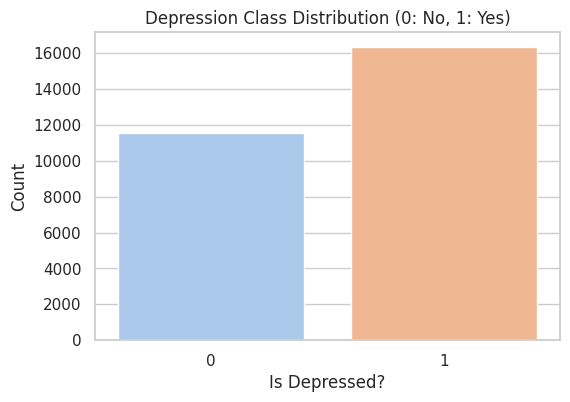

In [ ]:
# 使用纯 matplotlib 绘制抑郁标签分布，并在图中显示百分比
label_counts = data['Depression'].value_counts().sort_index()
labels = ['否', '是']
counts = [label_counts.get(0, 0), label_counts.get(1, 0)]
total = sum(counts) if sum(counts) > 0 else 1
plt.figure(figsize=(6, 4))
bars = plt.bar(labels, counts, color=['#9ecae1', '#fdae6b'], edgecolor='black')
for bar, cnt in zip(bars, counts):
    pct = cnt / total * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f"{cnt} ({pct:.1f}%)", ha='center', va='bottom', fontsize=10)
plt.title('抑郁样本分布（0=否，1=是）')
plt.xlabel('是否抑郁')
plt.ylabel('数量')
plt.ylim(0, max(counts) * 1.15 if counts else 1)
plt.tight_layout()
plt.show()

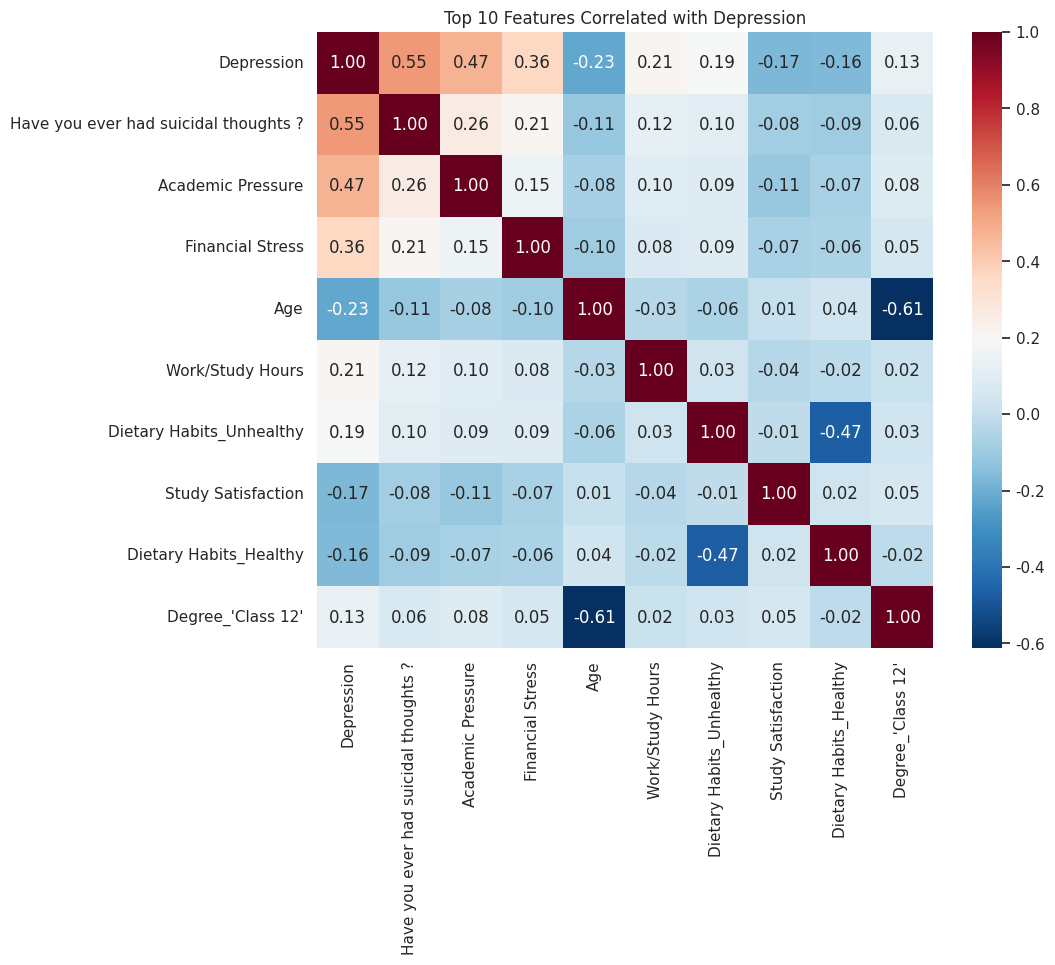

In [ ]:
corr = data_encoded.corr()
k = 10
topk = corr['Depression'].abs().sort_values(ascending=False).head(k).index  # 取“绝对值”相关性Top10，包含Depression
corr_topk = corr.loc[topk, topk]

# 2. 画相关性热力图
plt.figure(figsize=(10, 8))
sns.heatmap(corr_topk, annot=True, cmap='RdBu_r', fmt='.2f', square=True)
plt.title('与抑郁最相关的前10个特征')
plt.show()

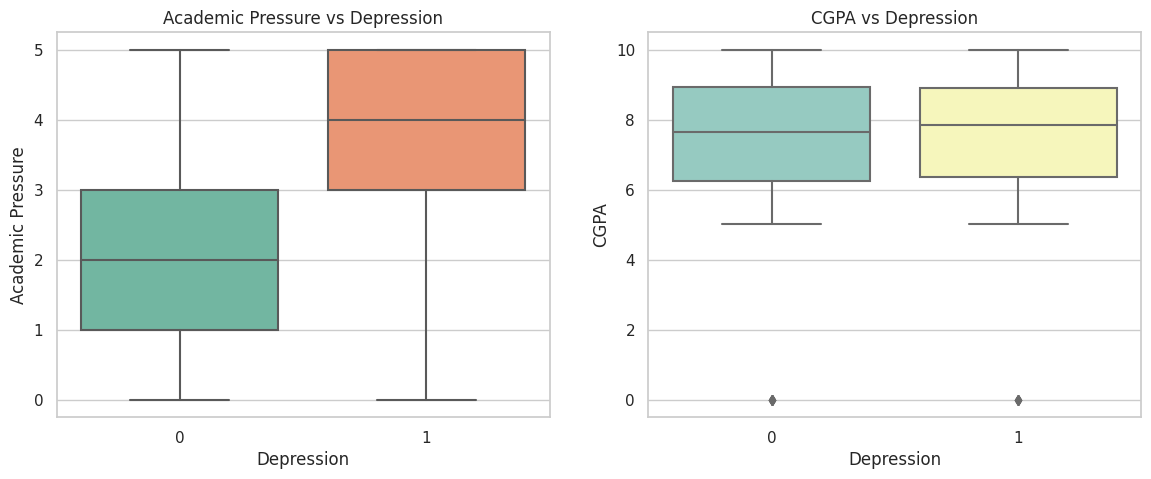

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# 左图：学业压力 vs 抑郁
sns.boxplot(x='Depression', y='Academic Pressure', data=data, ax=ax[0], palette='Set2')
ax[0].set_title('学业压力与抑郁的关系')
ax[0].set_xlabel('是否抑郁')
ax[0].set_ylabel('学业压力评分')

# 右图：CGPA vs 抑郁 (通常认为成绩越差可能压力越大?)
sns.boxplot(x='Depression', y='CGPA', data=data, ax=ax[1], palette='Set3')
ax[1].set_title('CGPA 与抑郁的关系')
ax[1].set_xlabel('是否抑郁')
ax[1].set_ylabel('CGPA')

plt.tight_layout()
plt.show()

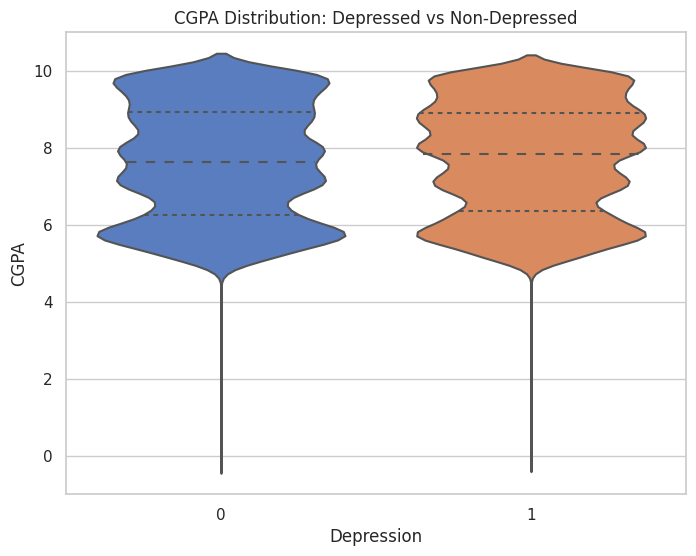

In [ ]:
plt.figure(figsize=(8, 6))

sns.violinplot(x='Depression', y='CGPA', data=data, 
               split=True, inner="quart", palette="muted")

plt.title('CGPA 分布：抑郁 vs 非抑郁')
plt.xlabel('是否抑郁')
plt.ylabel('CGPA')
plt.show()

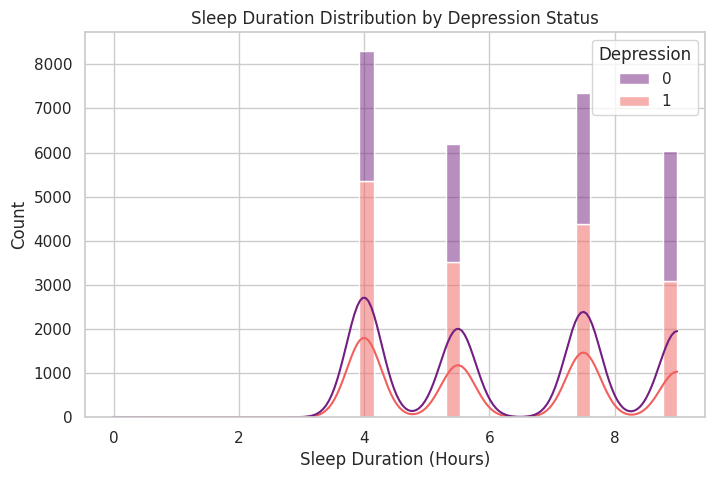

In [ ]:
# Matplotlib 版本的 Sleep Duration 分布，可选择堆叠展示
plt.figure(figsize=(8, 5))
bins = np.linspace(data['Sleep Duration'].min(), data['Sleep Duration'].max(), 15)
plt.hist([data.loc[data['Depression']==0, 'Sleep Duration'], data.loc[data['Depression']==1, 'Sleep Duration']],
         bins=bins, stacked=True, label=['未抑郁', '抑郁'], color=['#8dd3c7', '#fb8072'], edgecolor='black')
plt.title('睡眠时长分布（按抑郁状态分组）')
plt.xlabel('睡眠时长（小时）')
plt.ylabel('数量')
plt.legend()
plt.tight_layout()
plt.show()

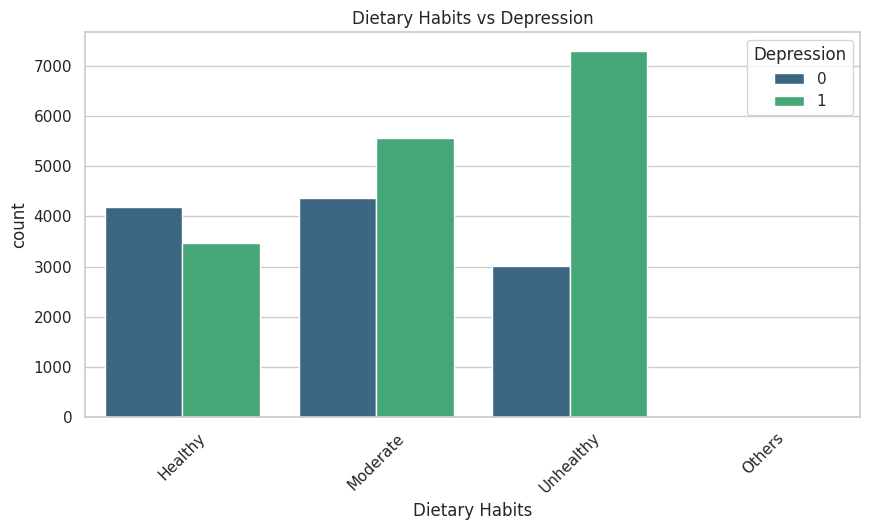

In [ ]:
# 使用 matplotlib 绘制饮食习惯与抑郁的分组柱状图
plt.figure(figsize=(10, 5))
diet_counts = data.groupby(['Dietary Habits', 'Depression']).size().unstack(fill_value=0)
x = np.arange(len(diet_counts.index))
width = 0.35
bars0 = plt.bar(x - width/2, diet_counts[0], width, label='未抑郁', color='#a6cee3', edgecolor='black')
bars1 = plt.bar(x + width/2, diet_counts[1], width, label='抑郁', color='#b2df8a', edgecolor='black')
plt.xticks(x, diet_counts.index, rotation=45, ha='right')
plt.title('饮食习惯与抑郁关系')
plt.xlabel('饮食习惯')
plt.ylabel('数量')
plt.legend()
plt.tight_layout()
plt.show()

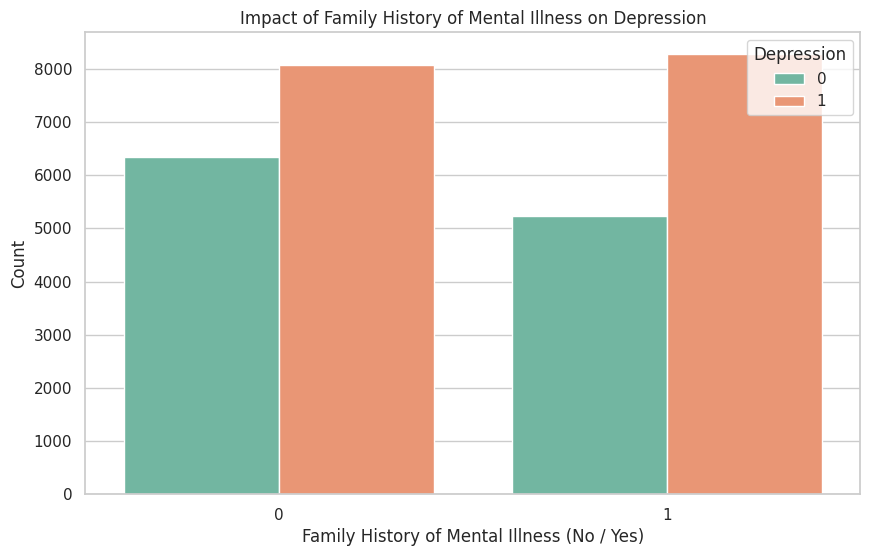

In [ ]:
plt.figure(figsize=(10, 6))

# hue='Depression' 表示按抑郁情况分颜色
sns.countplot(x='Family History of Mental Illness', hue='Depression', data=data, palette='Set2')

plt.title('家族精神疾病史对抑郁的影响')
plt.xlabel('是否有家族精神疾病史 (No / Yes)')
plt.ylabel('数量')
plt.legend(title='抑郁状态', labels=['未抑郁', '抑郁'], loc='upper right')
plt.tight_layout()
plt.show()


In [ ]:
# --- 1. 准备数据 ---
# 确保数据是干净的数值型 (沿用之前的修复)
# 假设 data_encoded 已经处理好了 NaN 和 '?'
X = data_encoded.drop(columns=['Depression'])  # 特征
y = data_encoded['Depression']                 # 目标变量 (0 或 1)
#修复
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)
# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_imputed, y, test_size=0.2, random_state=42)

# --- 2. 训练“侦探” (随机森林模型) ---
# 随机森林就像找了100个专家来投票，准确率通常很高
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

print("模型训练完毕！")
print(f"模型准确率 (Accuracy): {model.score(X_test, y_test):.2f}")

# --- 3. 宏观视角：谁是“幕后黑手”？(Feature Importance) ---
# 查看哪些特征对预测“是否抑郁”贡献最大
importances = model.feature_importances_
indices = np.argsort(importances)[::-1] # 降序排列

# 画出前10个最重要的特征
top_k = 10
plt.figure(figsize=(10, 6))
plt.title("前10个重要特征（随机森林）")
plt.bar(range(top_k), importances[indices[:top_k]], align="center", color='skyblue')
plt.xticks(range(top_k), X.columns[indices[:top_k]], rotation=45, ha='right')
plt.ylabel('特征重要性')
plt.tight_layout()
plt.show()

# --- 4. 微观视角：深层关系解读 (SHAP值 - 核心部分) ---
# SHAP图能告诉你：一个特征的值变大时，是推向“抑郁”还是“健康”？

# 计算SHAP值
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 绘制 SHAP Summary Plot (蜂群图)
plt.figure(figsize=(10, 8))
# shap_values[1] 代表预测为 "Depression=1" (抑郁) 的贡献情况
shap.summary_plot(shap_values[1], X_test, plot_type="dot", show=False)
plt.title('SHAP 深度分析：特征对抑郁风险的影响')
plt.show()

In [ ]:
# Matplotlib 动画：逐步长高的特征重要性柱状图
from IPython.display import HTML
top_k = min(10, len(importances))
feature_names = X.columns[indices[:top_k]]
feature_scores = importances[indices[:top_k]]
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(feature_names, np.zeros_like(feature_scores), color='#6baed6', edgecolor='black')
ax.set_ylim(0, feature_scores.max() * 1.2)
ax.set_ylabel('Importance')
ax.set_title('Animated Feature Importance Growth')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

def init():
    for bar in bars:
        bar.set_height(0)
    return bars

def update(frame):
    ratio = frame / 30
    for bar, val in zip(bars, feature_scores):
        bar.set_height(val * ratio)
    return bars

anim = animation.FuncAnimation(fig, update, frames=31, init_func=init, interval=120, blit=False)
HTML(anim.to_jshtml())

In [ ]:
# Matplotlib 动画：逐步长高的特征重要性柱状图
from IPython.display import HTML
top_k = min(10, len(importances))
feature_names = X.columns[indices[:top_k]]
feature_scores = importances[indices[:top_k]]
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(feature_names, np.zeros_like(feature_scores), color='#6baed6', edgecolor='black')
ax.set_ylim(0, feature_scores.max() * 1.2)
ax.set_ylabel('特征重要性')
ax.set_title('动画演示：前10个特征重要性逐步增长')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

def init():
    for bar in bars:
        bar.set_height(0)
    return bars

def update(frame):
    ratio = frame / 30
    for bar, val in zip(bars, feature_scores):
        bar.set_height(val * ratio)
    return bars

anim = animation.FuncAnimation(fig, update, frames=31, init_func=init, interval=120, blit=False)
HTML(anim.to_jshtml())